### Imports

In [96]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tqdm import tqdm
from sklearn.model_selection import KFold
from statistics import mean
from prettytable import PrettyTable

### Reading the data

* Climatic Indices

In [97]:
df1 = pd.read_csv('./climatic_indices/AO.txt', delimiter=',', header=None)
df2 = pd.read_csv('./climatic_indices/EPO.txt', delimiter=',', header=None)
df3 = pd.read_csv('./climatic_indices/NAO.txt', delimiter=',', header=None)
df4 = pd.read_csv('./climatic_indices/NINO12.txt', delim_whitespace=True, header=None)
df5 = pd.read_csv('./climatic_indices/NINO3.txt', delim_whitespace=True, header=None)
df6 = pd.read_csv('./climatic_indices/NINO34.txt', delim_whitespace=True, header=None)
df7 = pd.read_csv('./climatic_indices/NINO4.txt', delim_whitespace=True, header=None)
df8 = pd.read_csv('./climatic_indices/PNA.txt', delimiter=',', header=None)
df9 = pd.read_csv('./climatic_indices/SOI.txt', delim_whitespace=True)
df10 = pd.read_csv('./climatic_indices/WPO.txt', delimiter=',', header=None)

* Rainfall data

In [98]:
attigundi_df = pd.read_csv('./data/bhadra/rainfall_data/cleaned_data/Attigundi.csv')
balehonnur_df = pd.read_csv('./data/bhadra/rainfall_data/cleaned_data/Balehonnur.csv')
basarikatte_df = pd.read_csv('./data/bhadra/rainfall_data/cleaned_data/Basarikatte.csv')
kalasa_df = pd.read_csv('./data/bhadra/rainfall_data/cleaned_data/Kalasa.csv')
malandur_df = pd.read_csv('./data/bhadra/rainfall_data/cleaned_data/Malandur.csv')
narsimharajapura_df = pd.read_csv('./data/bhadra/rainfall_data/cleaned_data/Narsimharajapura.csv')

* Inflow and Evaporation

In [99]:
bhadra_data = pd.read_excel('./data/bhadra/Bhadara_data.xlsx')

In [100]:
# add a date column to bhadra_data dataframe with dates from 2004-6-1 to 2006-12-11
bhadra_data['date'] = pd.date_range(start='2004-6-1', end='2006-12-11', freq='D')
bhadra_data

,InFlow,Evaporation,date
0,129.82,3.07,2004-06-01
1,116.85,3.10,2004-06-02
2,148.88,3.13,2004-06-03
3,70.90,3.15,2004-06-04
4,54.91,3.16,2004-06-05
...,...,...,...
919,67.75,13.00,2006-12-07
920,67.76,13.01,2006-12-08
921,67.76,13.01,2006-12-09
922,68.77,13.02,2006-12-10


### Data Extraction on Common Timeline

In [101]:
def convert_single_to_datetime(df):
    df.iloc[:, 0] = df.iloc[:, 0].astype(str)
    df['date'] = pd.to_datetime(df.iloc[:, 0], format='%Y%m%d', errors='coerce')
    df.drop(df.columns[0], axis=1, inplace=True)
    return df

def convert_double_to_datetime(df):
    df['date_str'] = df.iloc[:, 0].astype(str) + df.iloc[:, 1].astype(str).str.zfill(3)
    df['date'] = pd.to_datetime(df['date_str'], format='%Y%j', errors='coerce')
    df.drop(df.columns[[0, 1]], axis=1, inplace=True)
    df.drop('date_str', axis=1, inplace=True)
    return df

def convert_triple_to_datetime(df):
    df['date_str'] = df.iloc[:, 0].astype(str) + df.iloc[:, 1].astype(str).str.zfill(2) + df.iloc[:, 2].astype(str).str.zfill(2)
    df['date'] = pd.to_datetime(df['date_str'], format='%Y%m%d', errors='coerce')
    df.drop(df.columns[[0, 1, 2]], axis=1, inplace=True)
    df.drop('date_str', axis=1, inplace=True)
    return df

def convert_column_to_datetime(df, column_name):
    df[column_name] = df[column_name].astype(str)
    df['date'] = pd.to_datetime(df[column_name], format='%Y%m%d', errors='coerce')
    df.drop(columns=[column_name], inplace=True)
    return df

In [102]:
ao_df = convert_triple_to_datetime(df1)
epo_df = convert_triple_to_datetime(df2)
nao_df = convert_triple_to_datetime(df3)
nino12_df = convert_single_to_datetime(df4)
nino3_df = convert_single_to_datetime(df5)
nino34_df = convert_single_to_datetime(df6)
nino4_df = convert_single_to_datetime(df7)
pna_df = convert_triple_to_datetime(df8)
soi_df = convert_double_to_datetime(df9)
wpo_df = convert_triple_to_datetime(df10)

attigundi_df = convert_triple_to_datetime(attigundi_df)
balehonnur_df = convert_triple_to_datetime(balehonnur_df)
basarikatte_df = convert_triple_to_datetime(basarikatte_df)
kalasa_df = convert_triple_to_datetime(kalasa_df)
malandur_df = convert_triple_to_datetime(malandur_df)
narsimharajapura_df = convert_triple_to_datetime(narsimharajapura_df)

In [103]:
def find_min_max_dates(dataframes):
    min_date = dataframes[0]['date'].min()
    max_date = dataframes[0]['date'].max()

    for df in dataframes:
        if 'date' in df.columns:
            df_min_date = df['date'].min()
            df_max_date = df['date'].max()
            min_date = max(min_date, df_min_date)
            max_date = min(max_date, df_max_date)

    return min_date, max_date

In [104]:
dataframes = [ao_df, epo_df, nao_df, nino12_df, nino3_df, nino34_df, nino4_df, pna_df, soi_df, wpo_df, attigundi_df, balehonnur_df, basarikatte_df, kalasa_df, malandur_df, narsimharajapura_df, bhadra_data]
min_date, max_date = find_min_max_dates(dataframes)

In [105]:
def reduce_dataframe_by_date_range(df, min_date, max_date):
    mask = (df['date'] >= min_date) & (df['date'] <= max_date)
    reduced_df = df.loc[mask].copy()
    reduced_df.reset_index(drop=True, inplace=True)
    return reduced_df

In [106]:
ao_df = reduce_dataframe_by_date_range(ao_df, min_date, max_date)
epo_df = reduce_dataframe_by_date_range(epo_df, min_date, max_date)
nao_df = reduce_dataframe_by_date_range(nao_df, min_date, max_date)
nino12_df = reduce_dataframe_by_date_range(nino12_df, min_date, max_date)
nino3_df = reduce_dataframe_by_date_range(nino3_df, min_date, max_date)
nino34_df = reduce_dataframe_by_date_range(nino34_df, min_date, max_date)
nino4_df = reduce_dataframe_by_date_range(nino4_df, min_date, max_date)
pna_df = reduce_dataframe_by_date_range(pna_df, min_date, max_date)
soi_df = reduce_dataframe_by_date_range(soi_df, min_date, max_date)
wpo_df = reduce_dataframe_by_date_range(wpo_df, min_date, max_date)

attigundi_df = reduce_dataframe_by_date_range(attigundi_df, min_date, max_date)
balehonnur_df = reduce_dataframe_by_date_range(balehonnur_df, min_date, max_date)
basarikatte_df = reduce_dataframe_by_date_range(basarikatte_df, min_date, max_date)
kalasa_df = reduce_dataframe_by_date_range(kalasa_df, min_date, max_date)
malandur_df = reduce_dataframe_by_date_range(malandur_df, min_date, max_date)
narsimharajapura_df = reduce_dataframe_by_date_range(narsimharajapura_df, min_date, max_date)

bhadra_data = reduce_dataframe_by_date_range(bhadra_data, min_date, max_date)

In [107]:
print(attigundi_df.shape, balehonnur_df.shape, basarikatte_df.shape, kalasa_df.shape, malandur_df.shape, narsimharajapura_df.shape)

(924, 2) (924, 2) (924, 2) (924, 2) (924, 2) (924, 2)


In [108]:
attigundi_df

,Data,date
0,14.7,2004-06-01
1,15.3,2004-06-02
2,18.5,2004-06-03
3,5.5,2004-06-04
4,0.3,2004-06-05
...,...,...
919,0.0,2006-12-07
920,0.0,2006-12-08
921,0.0,2006-12-09
922,0.0,2006-12-10


In [109]:
# create a precipitation dataframe with date and precipitation columns where precipitation is the average of all the stations
precipitation_df = pd.DataFrame()
precipitation_df['date'] = attigundi_df['date']
precipitation_df['Data'] = (attigundi_df['Data'] + balehonnur_df['Data'] + basarikatte_df['Data'] + kalasa_df['Data'] + malandur_df['Data'] + narsimharajapura_df['Data']) / 6
precipitation_df

,date,Data
0,2004-06-01,15.466667
1,2004-06-02,7.900000
2,2004-06-03,40.900000
3,2004-06-04,4.183333
4,2004-06-05,1.433333
...,...,...
919,2006-12-07,0.000000
920,2006-12-08,0.000000
921,2006-12-09,0.000000
922,2006-12-10,0.000000


In [110]:
ao = pd.DataFrame()
epo = pd.DataFrame()
nao = pd.DataFrame()
nino12 = pd.DataFrame()
nino3 = pd.DataFrame()
nino34 = pd.DataFrame()
nino4 = pd.DataFrame()
pna = pd.DataFrame()
soi = pd.DataFrame()
wpo = pd.DataFrame()
bhadra_inflow = pd.DataFrame()
bhadra_evaporation = pd.DataFrame()
bhadra_precipitation = pd.DataFrame()
seasonality = pd.DataFrame()

In [111]:
epo_df

,3,date
0,49.25,2004-06-01
1,35.56,2004-06-02
2,3.45,2004-06-03
3,13.88,2004-06-04
4,36.74,2004-06-05
...,...,...
919,37.59,2006-12-07
920,95.28,2006-12-08
921,88.18,2006-12-09
922,124.91,2006-12-10


In [112]:
ao['VALUE'] = ao_df.iloc[:, 0]
epo['VALUE'] = epo_df.iloc[:, 0]
nao['VALUE'] = nao_df.iloc[:, 0]
nino12['VALUE'] = nino12_df.iloc[:, 0]
nino3['VALUE'] = nino3_df.iloc[:, 0]
nino34['VALUE'] = nino34_df.iloc[:, 0]
nino4['VALUE'] = nino4_df.iloc[:, 0]
pna['VALUE'] = pna_df.iloc[:, 0]
soi['VALUE'] = soi_df.iloc[:, 0]
wpo['VALUE'] = wpo_df.iloc[:, 0]
bhadra_inflow['VALUE'] = bhadra_data['InFlow'].copy()
bhadra_evaporation['VALUE'] = bhadra_data['Evaporation'].copy()
bhadra_precipitation['VALUE'] = precipitation_df.iloc[:, 1].copy()

In [113]:
# create a seasonality dataframe with a column called seasonality that stores the month values of the date column
seasonality['VALUE'] = precipitation_df['date'].dt.month

In [114]:
nao

,VALUE
0,-51.48
1,-7.24
2,27.21
3,28.85
4,23.66
...,...
919,122.76
920,75.16
921,126.38
922,254.36


In [115]:
epo

,VALUE
0,49.25
1,35.56
2,3.45
3,13.88
4,36.74
...,...
919,37.59
920,95.28
921,88.18
922,124.91


### Checking if NULL values exist

In [116]:
are_missing = 0
dfs = [ao, epo, nao, nino12, nino3, nino34, nino4, pna, soi, wpo, bhadra_inflow, bhadra_evaporation, bhadra_precipitation, seasonality]
df_names =  ['AO', 'EPO', 'NAO', 'NINO12', 'NINO3', 'NINO34', 'NINO4', 'PNA', 'SOI', 'WPO', 'bhadra_inflow', 'bhadra_precipitation', 'bhadra_precipitation']
for i, df in enumerate(dfs):
    if df.isna().any().any():
        are_missing = 1
        print(f"{df_names[i]} has NaN values.")

if are_missing == 0:
    print("\nThere are no missing values in any of the dataframes")


There are no missing values in any of the dataframes


### Convert Object type to float

In [117]:
def converttofloat(s):
  count = 0
  s = str(s)
  v = float(s.replace(',',''))
  if v < 0:
    count +=1
    return np.nan
  else:
    return v

In [118]:
bhadra_inflow['VALUE'] = bhadra_inflow['VALUE'].apply(converttofloat)
bhadra_evaporation['VALUE'] = bhadra_evaporation['VALUE'].apply(converttofloat)
bhadra_precipitation['VALUE'] = bhadra_precipitation['VALUE'].apply(converttofloat)
seasonality['VALUE'] = seasonality['VALUE'].apply(converttofloat)

### Unit Conversion

In [119]:
def mcfttom3s(value):
  value = (value*28316.8466)/(24*60*60*1.0)
  return value

In [120]:
bhadra_inflow['VALUE'] = bhadra_inflow['VALUE'].apply(mcfttom3s)
bhadra_evaporation['VALUE'] = bhadra_evaporation['VALUE'].apply(mcfttom3s)

### Data Visualization

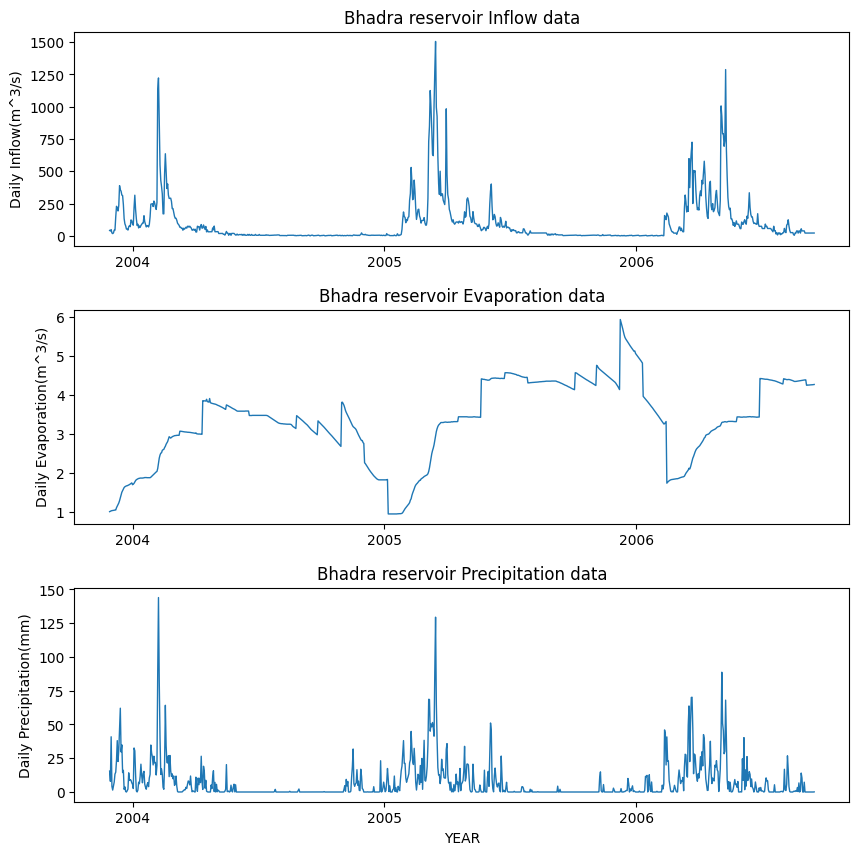

In [121]:
a = list(bhadra_inflow['VALUE'])
b = list(bhadra_evaporation['VALUE'])
c = list(bhadra_precipitation['VALUE'])
fig,ax = plt.subplots(3,1,figsize=(10,10))
plt.setp(ax, xticks=np.arange(30,960,step=330),xticklabels=['2004','2005','2006'])
ax[0].plot(a,linewidth=1)
ax[0].set_title('Bhadra reservoir Inflow data')
ax[0].set_ylabel('Daily Inflow(m^3/s)')
ax[1].plot(b, linewidth=1)
ax[1].set_title('Bhadra reservoir Evaporation data')
ax[1].set_ylabel('Daily Evaporation(m^3/s)')
ax[2].plot(c,linewidth=1)
ax[2].set_title('Bhadra reservoir Precipitation data')
ax[2].set_ylabel('Daily Precipitation(mm)')
plt.xlabel('YEAR')

fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.savefig("Bhadra.png")
plt.show()

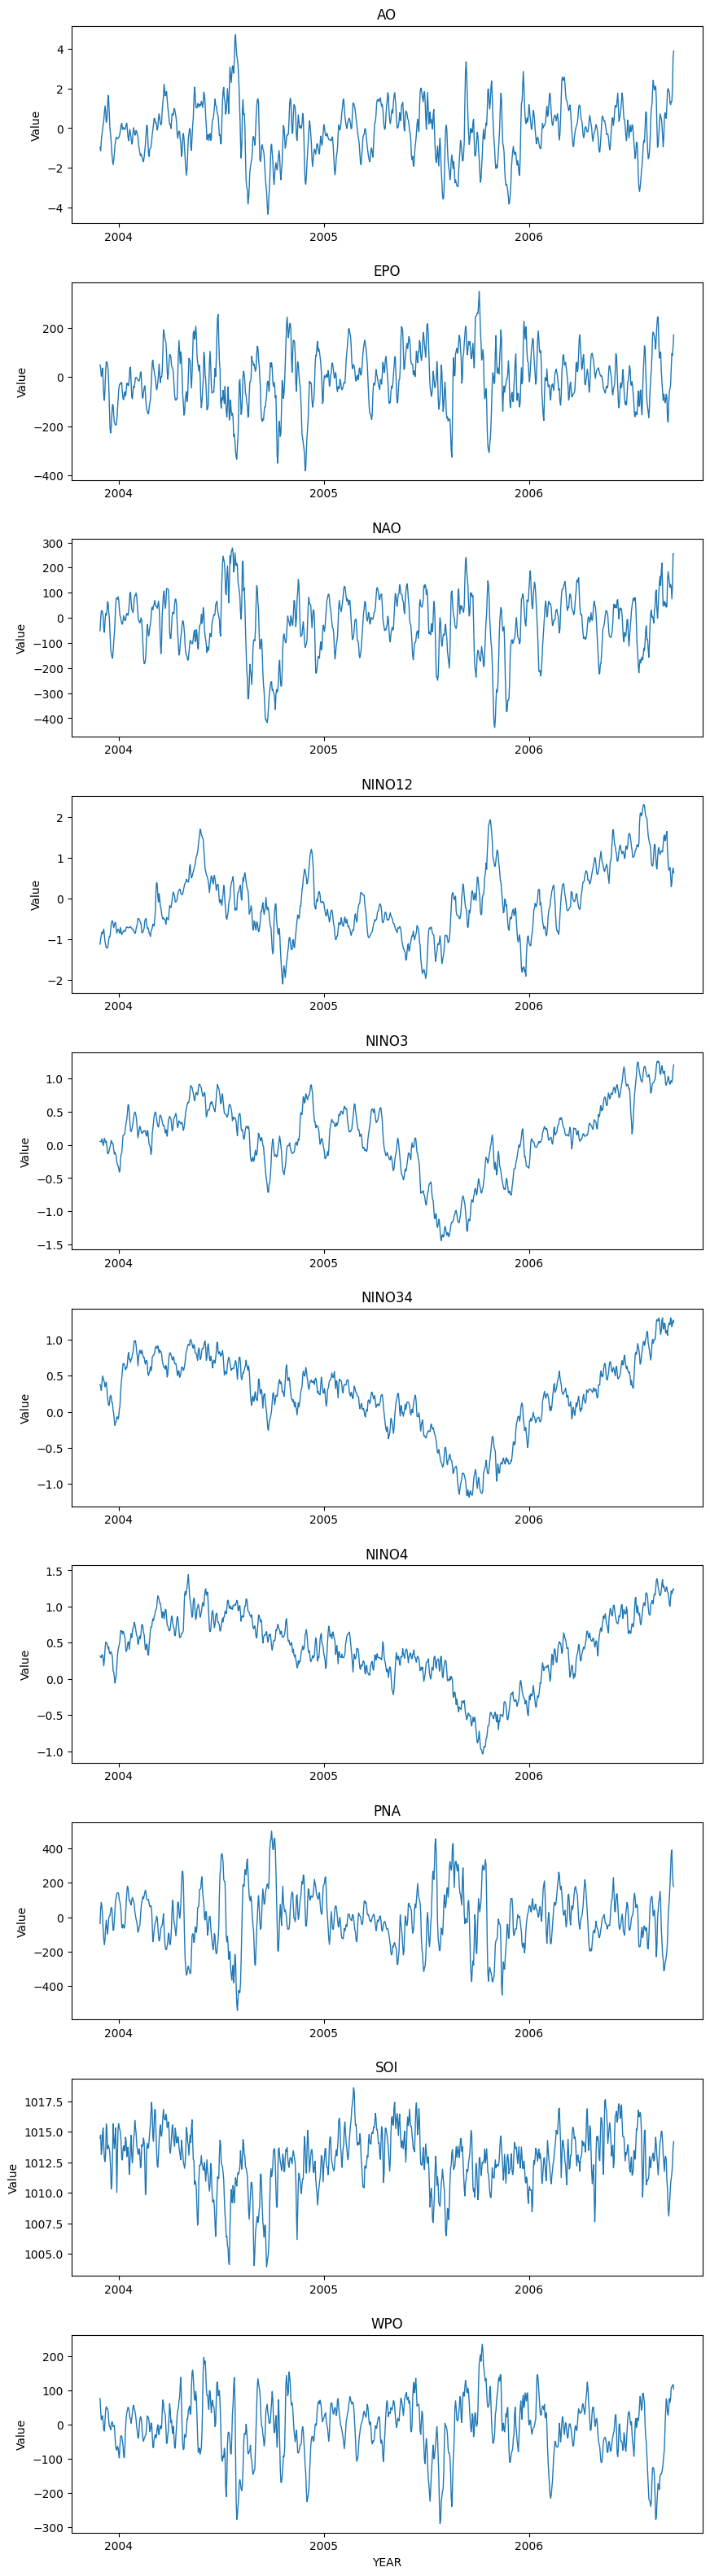

In [122]:
# plot climatic indices
fig,ax = plt.subplots(10,1,figsize=(10,40))
plt.setp(ax, xticks=np.arange(30,960,step=330),xticklabels=['2004','2005','2006'])
names = ['AO', 'EPO', 'NAO', 'NINO12', 'NINO3', 'NINO34', 'NINO4', 'PNA', 'SOI', 'WPO']
for i, index in enumerate([ao, epo, nao, nino12, nino3, nino34, nino4, pna, soi, wpo]):
    ax[i].plot(index,linewidth=1)
    ax[i].set_title(names[i])
    ax[i].set_ylabel('Value')

plt.xlabel('YEAR')
fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.savefig("climatic_indices.png")
plt.show()

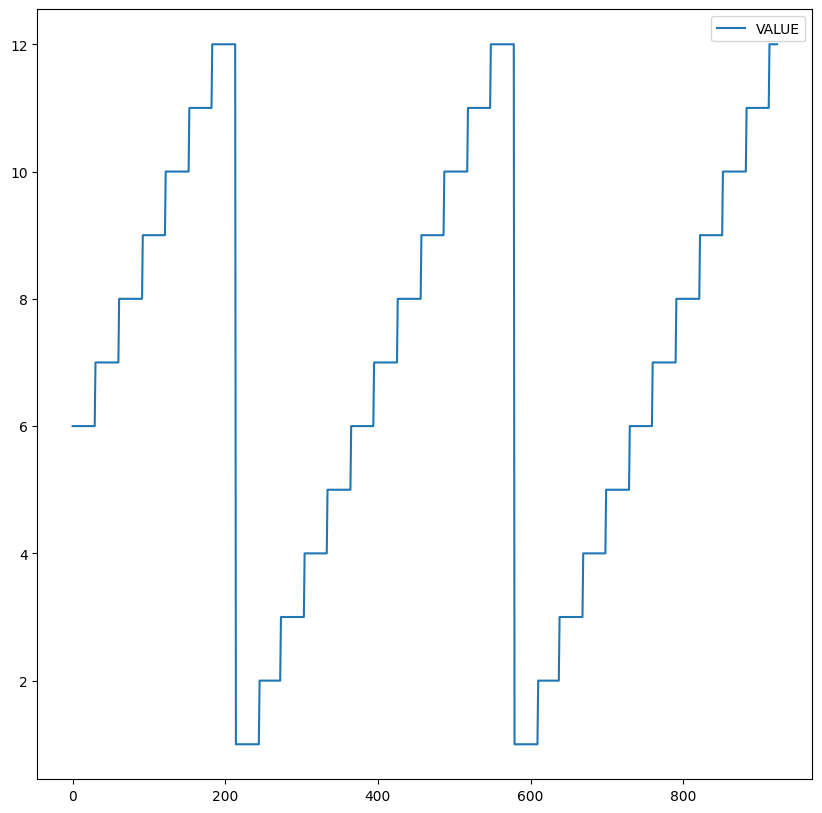

In [123]:
seasonality.plot(figsize=(10,10))
plt.show()

### Checking Autocorrelation

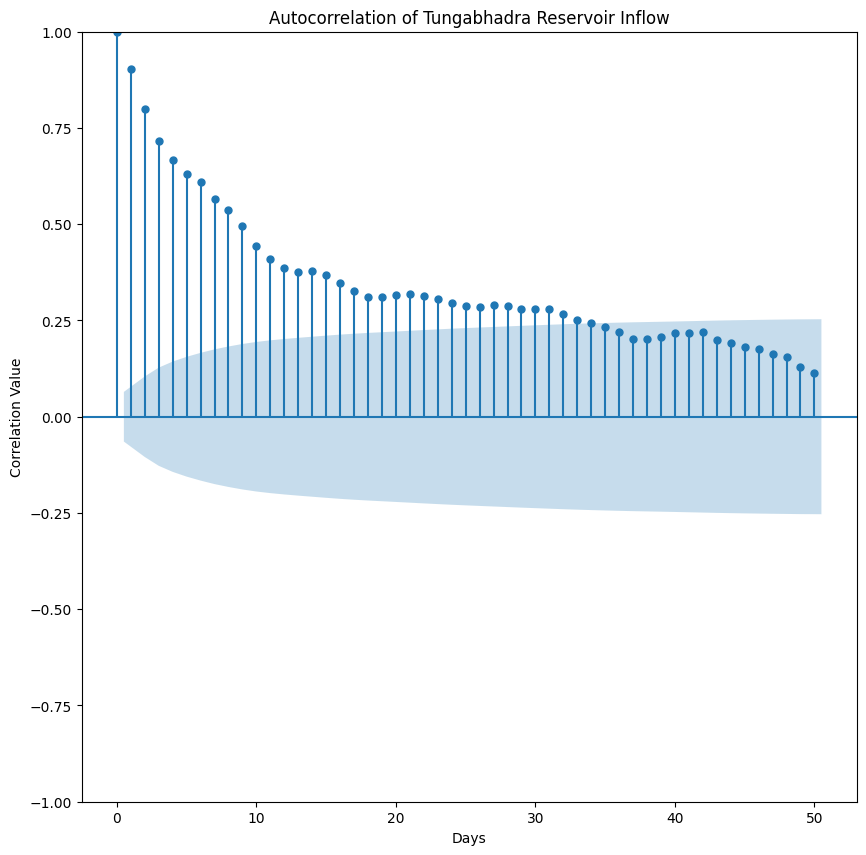

In [124]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_acf(bhadra_inflow,lags=50)
  plt.ylabel('Correlation Value')
  plt.xlabel('Days')
  plt.title('Autocorrelation of Tungabhadra Reservoir Inflow')
  plt.show()

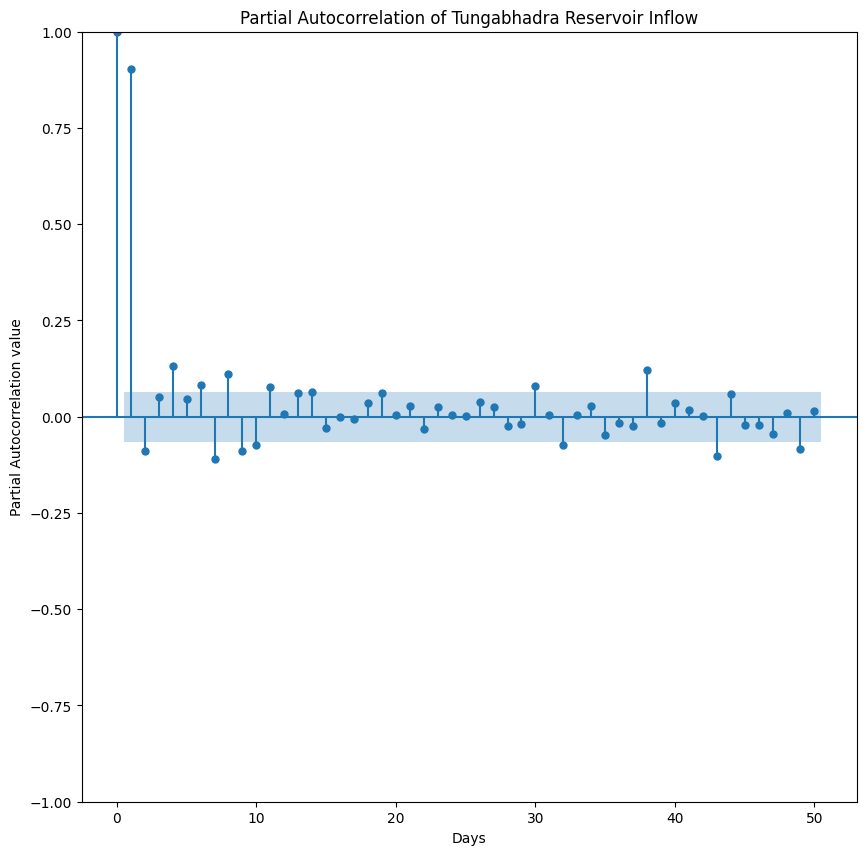

In [125]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_pacf(bhadra_inflow,lags=50)
  plt.xlabel('Days')
  plt.ylabel('Partial Autocorrelation value')
  plt.title('Partial Autocorrelation of Tungabhadra Reservoir Inflow')
  plt.show()

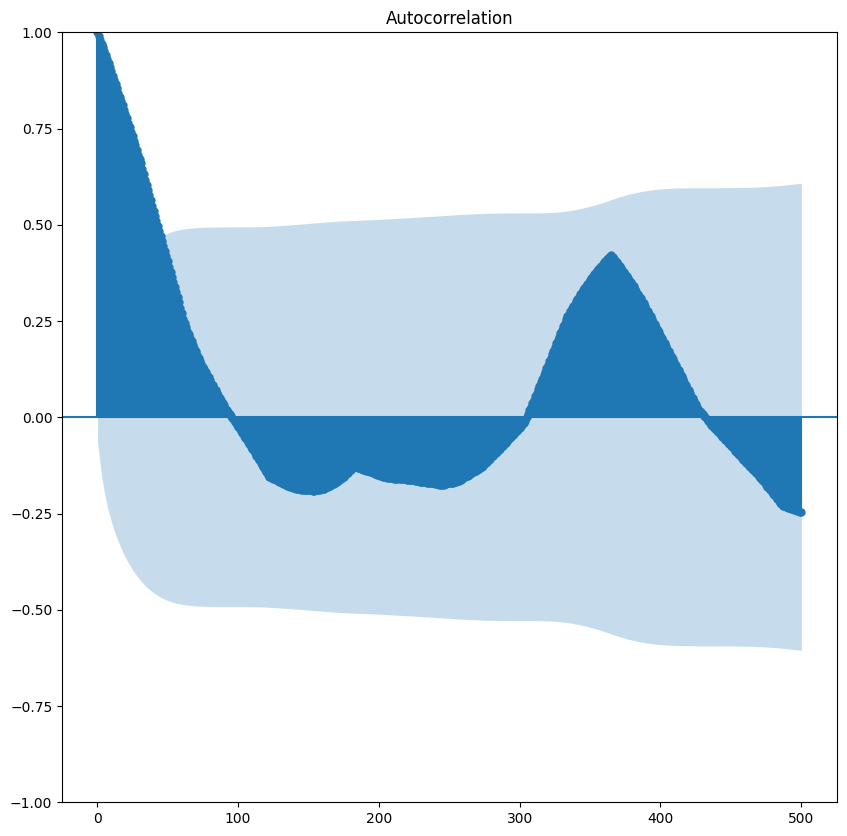

In [126]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_acf(bhadra_evaporation,lags=500)
  plt.show()

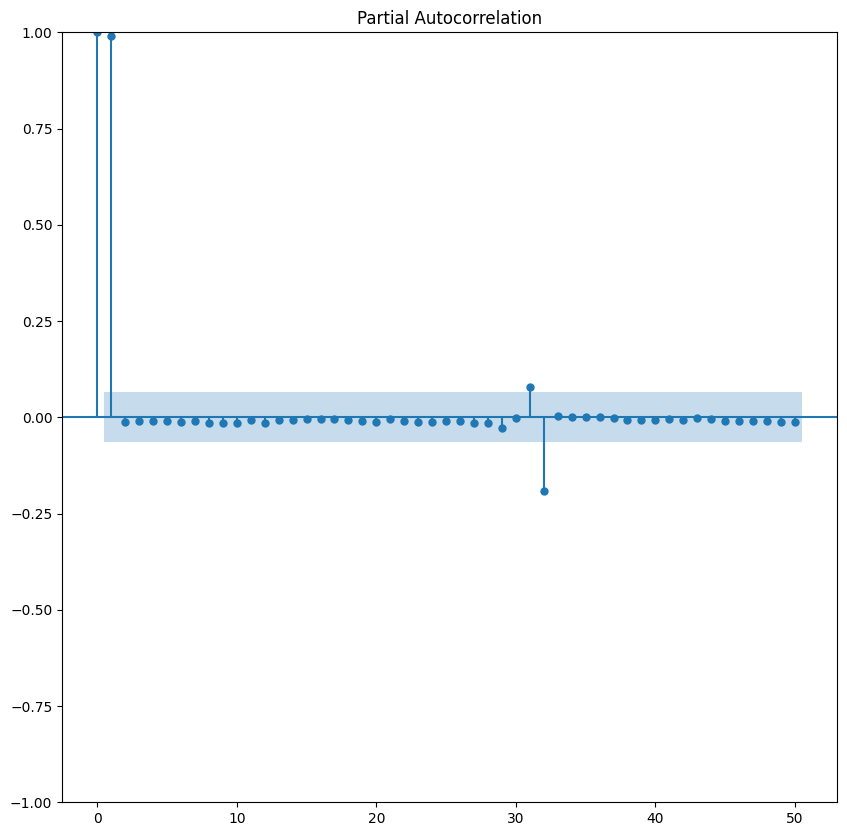

In [127]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_pacf(bhadra_evaporation,lags=50)
  plt.show()

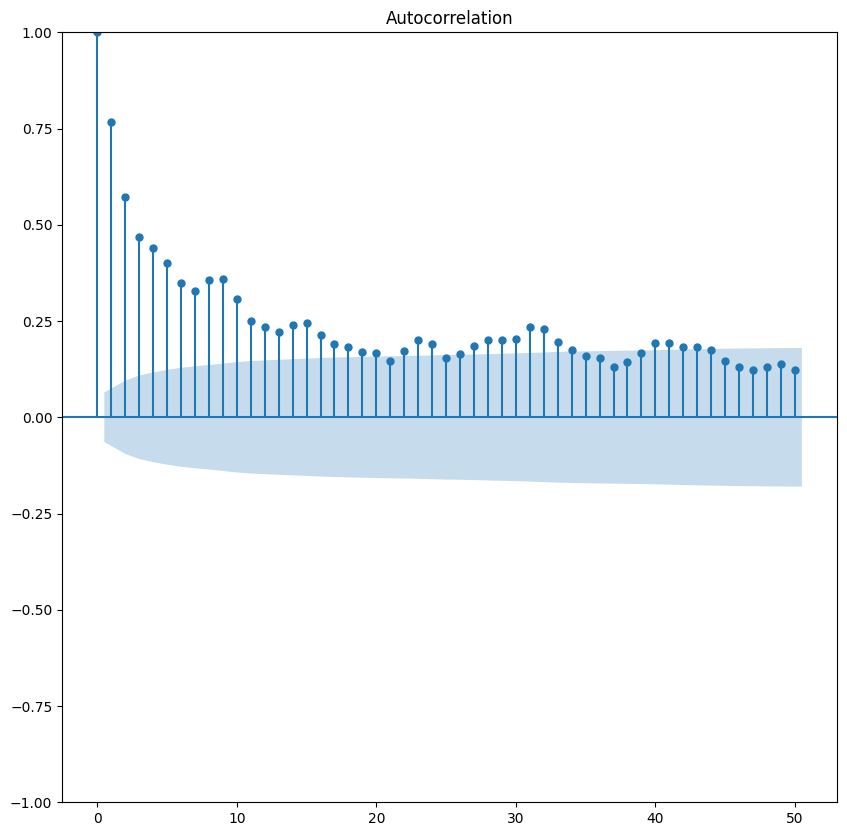

In [128]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_acf(bhadra_precipitation,lags=50)
  plt.show()

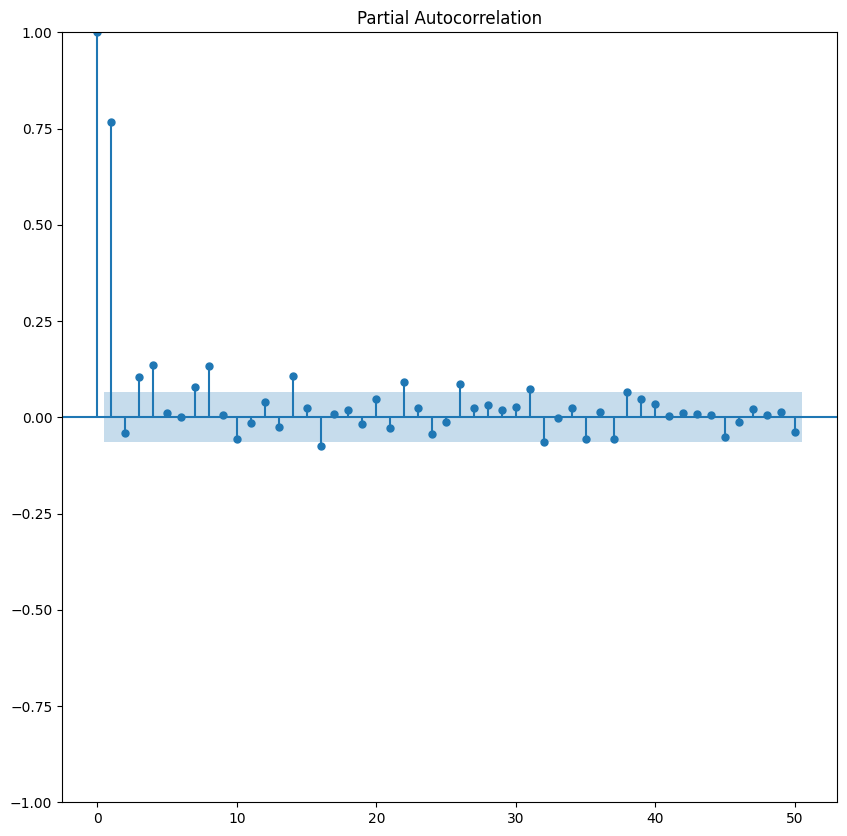

In [129]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_pacf(bhadra_precipitation,lags=50)
  plt.show()

### Preparing Lagged Dataset

In [130]:
def generate_lagged_data(data, data_name, lag):
    data_lag = pd.DataFrame()
    for i in range(lag,0,-1):
        data_lag[data_name+'-'+str(i)] = data.shift(i).values[:,0]
    data_lag[data_name] = data.values[:,0]
    data_lag = data_lag[lag+1:]
    return data_lag

In [131]:
lag = 2

ao_lag = generate_lagged_data(ao, 'ao_t', lag)
epo_lag = generate_lagged_data(epo, 'epo_t', lag)
nao_lag = generate_lagged_data(nao, 'nao_t', lag)
nino12_lag = generate_lagged_data(nino12, 'nino12_t', lag)
nino3_lag = generate_lagged_data(nino3, 'nino3_t', lag)
nino34_lag = generate_lagged_data(nino34, 'nino34_t', lag)
nino4_lag = generate_lagged_data(nino4, 'nino4_t', lag)
pna_lag = generate_lagged_data(pna, 'pna_t', lag)
soi_lag = generate_lagged_data(soi, 'soi_t', lag)
wpo_lag = generate_lagged_data(wpo, 'wpo_t', lag)
seasonality_lag = generate_lagged_data(seasonality, 'seasonality_t', lag)

bhadra_evaporation_lag = generate_lagged_data(bhadra_evaporation, 'bhadra_evaporation_t', lag)
bhadra_precipitation_lag = generate_lagged_data(bhadra_precipitation, 'bhadra_precipitation_t', lag)

In [132]:
bhadra_inflow_lag = pd.DataFrame()
inflow = pd.DataFrame()
for i in range(lag,0,-1):
	bhadra_inflow_lag['inflow_t-'+str(i)] = bhadra_inflow.shift(i).values[:,0]
inflow['VALUE'] = bhadra_inflow.values[:,0]
bhadra_inflow_lag = bhadra_inflow_lag[lag+1:]
inflow = inflow[lag+1:]

### Formatting Dataset

In [133]:
# df_list = [ao_lag,epo_lag,nao_lag,nino12_lag,nino3_lag,nino34_lag,nino4_lag,pna_lag,soi_lag,wpo_lag,seasonality_lag,bhadra_evaporation_lag,bhadra_precipitation_lag,bhadra_inflow_lag]
df_list = [ao, epo, nao, nino12, nino3, nino34, nino4, pna, soi, wpo, seasonality, bhadra_evaporation, bhadra_precipitation, bhadra_inflow]
X = pd.concat(df_list,axis=1)
y = bhadra_inflow.copy()

In [134]:
X

,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE
0,-0.968828,49.25,-51.48,-1.119204,0.051680,0.377649,0.315521,-36.64,1014.48,76.43,6.0,1.006166,15.466667,42.547373
1,-1.133935,35.56,-7.24,-0.970147,0.048462,0.354378,0.302780,51.56,1014.73,40.43,6.0,1.015998,7.900000,38.296569
2,-0.655204,3.45,27.21,-0.916696,0.044242,0.295499,0.294536,85.64,1013.14,14.35,6.0,1.025830,40.900000,48.794122
3,-0.328057,13.88,28.85,-0.821221,0.092725,0.391359,0.334081,62.14,1013.51,23.15,6.0,1.032385,4.183333,23.236857
4,-0.091192,36.74,23.66,-0.862896,0.037648,0.497661,0.328305,8.42,1014.91,26.06,6.0,1.035662,1.433333,17.996274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,1.336661,37.59,122.76,0.290379,0.963672,1.276974,1.216195,372.65,1011.19,108.47,12.0,4.260637,0.000000,22.204472
920,1.342385,95.28,75.16,0.376370,0.938732,1.179604,1.176945,391.14,1011.58,110.37,12.0,4.263914,0.000000,22.207749
921,1.971601,88.18,126.38,0.672375,0.992565,1.210547,1.202079,268.29,1012.35,114.92,12.0,4.263914,0.000000,22.207749
922,3.575359,124.91,254.36,0.748058,1.150309,1.271407,1.245922,189.66,1013.70,117.59,12.0,4.267191,0.000000,22.538768


In [135]:
y

,VALUE
0,42.547373
1,38.296569
2,48.794122
3,23.236857
4,17.996274
...,...
919,22.204472
920,22.207749
921,22.207749
922,22.538768


### Standardizing Dataset

In [136]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

### PCA

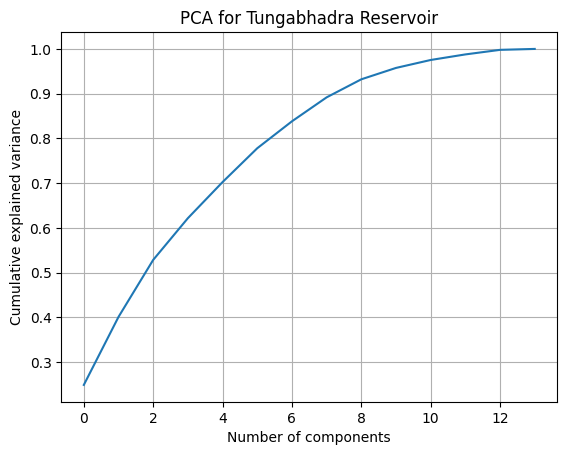

In [137]:
pca = PCA().fit(X_scaler)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA for Tungabhadra Reservoir')
plt.grid()
plt.show()

### Measurement

In [138]:
def correlation(s, o):
    if s.size == 0:
        corr = np.NaN
    else:
        corr = np.corrcoef(o, s)[0,1]
    return corr

def NS(s, o):
    return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)

def KGE(s, o):
    cc = correlation(s,o)
    alpha = np.std(s)/np.std(o)
    beta = np.sum(s)/np.sum(o)
    kge = 1- np.sqrt( (cc-1)**2 + (alpha-1)**2 + (beta-1)**2 )
    return kge
  
from scipy.stats import pearsonr
def CORR(s,o):
  corr, _ = pearsonr(test,preds)
  return corr
def Absolute_Percentage_Error(s,o):
  return (np.sum(np.abs(s-o))/np.sum(o))*100

In [139]:
# taking 20 components as these contain almost 95% of the variance
# pca = PCA(n_components=20)
# X_pca = pca.fit_transform(X_scaler)

In [140]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you have your feature matrix X and target variable y
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_scaler, np.array(y['VALUE']))

importances = regressor.feature_importances_
feature_ranking = sorted(zip(importances, range(len(importances))), reverse=True)

def prune_features(feature_ranking, threshold):
    pruned_features = []
    for importance, index in feature_ranking:
        if importance >= threshold:
            pruned_features.append(index)
        else:
            break
    return pruned_features

threshold = 0.03
pruned_features = prune_features(feature_ranking, threshold)



In [141]:
X_pca = X_scaler[:, pruned_features]

In [142]:
# rf = RandomForestRegressor(n_estimators=10,max_depth=5,min_samples_leaf=4)
# kf = KFold(n_splits=3,shuffle=False)
# score_rf_50 = []
# corr_rf_50 = []
# r2_rf_50 = []
# mae_rf_50 = []
# apb_50 = []
# nse_50 = []
# kge_50 = []
# r_rf_1 = []
# p_rf_1 = []
# for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
#     X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
#     rf.fit(X_train, y_train)
#     y_list_pred = list(rf.predict(X_test))
#     y_pred = np.array(y_list_pred)
#     y_real_list = list(y_test['VALUE'])
#     r_rf_1.extend(y_real_list)
#     p_rf_1.extend(y_list_pred)
#     y_real = np.array(y_real_list)
#     score_rf_50.append(math.sqrt(mean_squared_error(y_real, y_pred)))
#     corr_rf_50.append(correlation(y_real,y_pred))
#     r2_rf_50.append(r2_score(y_real,y_pred))
#     mae_rf_50.append(mean_absolute_error(y_real,y_pred))
#     apb_50.append(Absolute_Percentage_Error(y_real,y_pred))
#     nse_50.append(NS(y_real,y_pred))
#     kge_50.append(KGE(y_real,y_pred))

In [143]:
# print('RMSE ',mean(score_rf_50))
# print('CORR ',mean(corr_rf_50))
# print('R2 ',mean(r2_rf_50))
# print('MAE ',mean(mae_rf_50))
# print('APB ', mean(apb_50))
# print('KGE ',mean(kge_50))
# print('NS ',mean(nse_50))

In [144]:
rf_table = PrettyTable()
rf_table.field_names = ["n_estimators", "RMSE", "CORR", "R2", "MAE", "APB", "KGE", "NS"]
for n in [100, 200, 300, 400, 500]:
    rf = RandomForestRegressor(n_estimators=n)
    kf = KFold(n_splits=3,shuffle=False)
    score_rf_500 = []
    corr_rf_500 = []
    r2_rf_500 = []
    mae_rf_500 = []
    apb_500 = []
    nse_500 = []
    kge_500 = []
    r_rf_6 = []
    p_rf_6 = []
    for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
        X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        y_list_pred = list(rf.predict(X_test))
        y_pred = np.array(y_list_pred)
        y_real_list = list(y_test['VALUE'])
        y_real = np.array(y_real_list)
        r_rf_6.extend(y_real_list)
        p_rf_6.extend(y_list_pred)
        score_rf_500.append(math.sqrt(mean_squared_error(y_real, y_pred)))
        corr_rf_500.append(correlation(y_real,y_pred))
        r2_rf_500.append(r2_score(y_real,y_pred))
        mae_rf_500.append(mean_absolute_error(y_real,y_pred))
        apb_500.append(Absolute_Percentage_Error(y_real,y_pred))
        nse_500.append(NS(y_real,y_pred))
        kge_500.append(KGE(y_real,y_pred))

    rf_table.add_row([n, mean(score_rf_500), mean(corr_rf_500), mean(r2_rf_500), mean(mae_rf_500), mean(apb_500), mean(kge_500), mean(nse_500)])

print(rf_table)

k-fold:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_617508/2091515988.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
k-fold:  33%|███▎      | 1/3 [00:00<00:00,  7.37it/s]/tmp/ipykernel_617508/2091515988.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
k-fold:  67%|██████▋   | 2/3 [00:00<00:00,  7.58it/s]/tmp/ipykernel_617508/2091515988.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
k-fold:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_617508/2091515988.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| n_estimators |        RMSE       |        CORR        |         R2         |        MAE         |        APB         |        KGE         |         NS         |
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     100      | 7.922029767121357 | 0.9990242592584085 | 0.997767169813755  | 1.205504254597464  | 1.1729792025889723 | 0.9858357061105887 | 0.9976482259070958 |
|     200      | 7.811818669272819 | 0.9990776900221979 | 0.9978516550833119 | 1.2390201100719471 | 1.1980566242294595 | 0.986145451670174  | 0.997734267723482  |
|     300      | 8.028485476524086 | 0.9990335935388511 | 0.9977169276438033 | 1.2902722311541024 | 1.2493028312677146 | 0.9856562427368167 | 0.9975822121934248 |
|     400      | 7.991

In [145]:
print(rf_table)

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| n_estimators |        RMSE       |        CORR        |         R2         |        MAE         |        APB         |        KGE         |         NS         |
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     100      | 7.922029767121357 | 0.9990242592584085 | 0.997767169813755  | 1.205504254597464  | 1.1729792025889723 | 0.9858357061105887 | 0.9976482259070958 |
|     200      | 7.811818669272819 | 0.9990776900221979 | 0.9978516550833119 | 1.2390201100719471 | 1.1980566242294595 | 0.986145451670174  | 0.997734267723482  |
|     300      | 8.028485476524086 | 0.9990335935388511 | 0.9977169276438033 | 1.2902722311541024 | 1.2493028312677146 | 0.9856562427368167 | 0.9975822121934248 |
|     400      | 7.991

### Best RF

In [146]:
rf = RandomForestRegressor(n_estimators=400)
kf = KFold(n_splits=3,shuffle=False)
score_rf_400 = []
corr_rf_400 = []
r2_rf_400 = []
mae_rf_400 = []
apb_400 = []
nse_400 = []
kge_400 = []
r_rf = []
p_rf = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    r_rf.extend(y_real_list)
    p_rf.extend(y_list_pred)
    score_rf_400.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    corr_rf_400.append(correlation(y_real,y_pred))
    r2_rf_400.append(r2_score(y_real,y_pred))
    mae_rf_400.append(mean_absolute_error(y_real,y_pred))
    apb_400.append(Absolute_Percentage_Error(y_real,y_pred))
    nse_400.append(NS(y_real,y_pred))
    kge_400.append(KGE(y_real,y_pred))

k-fold:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_617508/3246300732.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
k-fold:  33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]/tmp/ipykernel_617508/3246300732.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
k-fold:  67%|██████▋   | 2/3 [00:01<00:00,  1.54it/s]/tmp/ipykernel_617508/3246300732.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
k-fold: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


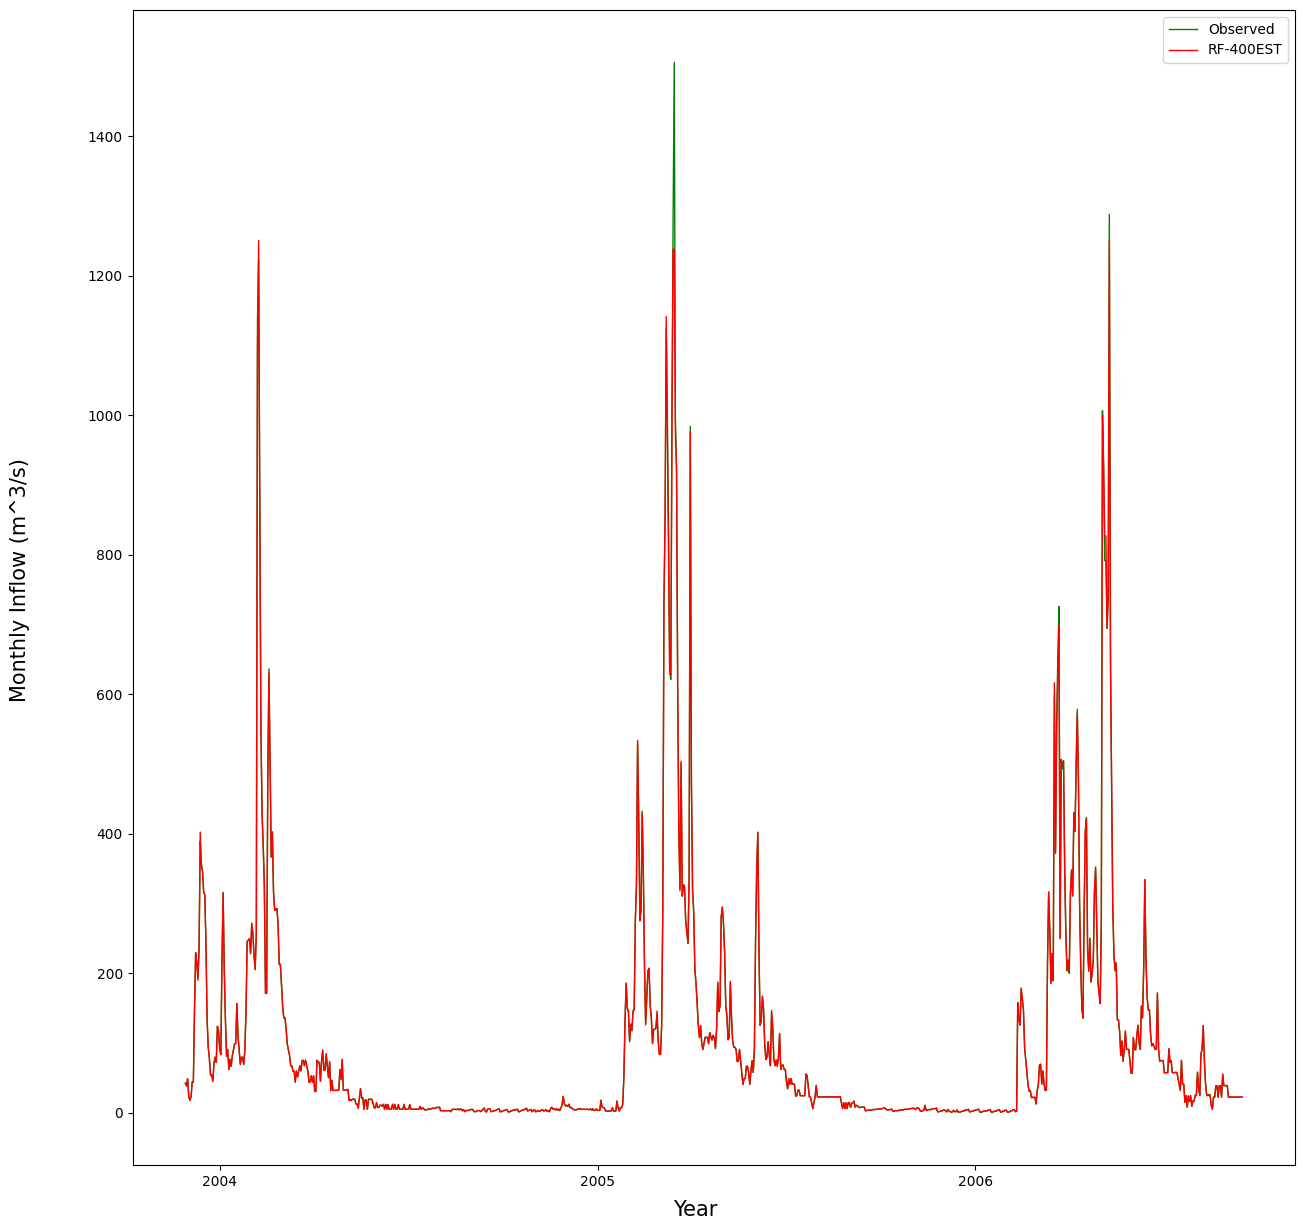

In [147]:
# plot r_rf and p_rf on the same graph
fig,ax = plt.subplots(1,1,figsize=(15,15))
plt.setp(ax, xticks=np.arange(30,960,step=330),xticklabels=['2004','2005','2006'])
fig.text(0.5, 0.08, 'Year', ha='center', va='center',fontsize=15)
fig.text(0.05, 0.5, 'Monthly Inflow (m^3/s)', ha='center', va='center', rotation='vertical',fontsize=15)
ax.plot(r_rf,"green",label='Observed',linewidth=1.0)
ax.plot(p_rf,"red",label='RF-400EST',linewidth=1.0)
ax.legend(prop={'size': 10})

In [148]:
gbr_table = PrettyTable()
gbr_table.field_names = ["n_estimators", "RMSE", "CORR", "R2", "MAE", "APB", "KGE", "NS"]
for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500, 600, 1000, 1500, 2000, 10000]:
    gbr = GradientBoostingRegressor(n_estimators=n)
    kf = KFold(n_splits=3, shuffle=False)
    gbr_score_1 = []
    def_gbr_score1_corr = []
    def_gbr_score1_mae = []
    def_gbr_score1_r2 = []
    def_gbr_score1_apb =[]
    def_gbr_score1_nse = []
    def_gbr_score1_kge = []
    r_gbr_6 = []
    p_gbr_6 = []
    for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
        X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
        gbr.fit(X_train, y_train)
        y_list_pred = list(gbr.predict(X_test))
        for i in range(len(y_list_pred)):
            if y_list_pred[i] < 0:
                y_list_pred[i] = 0
        y_pred = np.array(y_list_pred)
        y_list_real = list(y_test['VALUE'])
        y_real = np.array(y_list_real)
        r_gbr_6.extend(y_list_real)
        p_gbr_6.extend(y_list_pred)
        gbr_score_1.append(math.sqrt(mean_squared_error(y_real, y_pred)))
        def_gbr_score1_corr.append(correlation(y_real,y_pred))
        def_gbr_score1_mae.append(mean_absolute_error(y_real,y_pred))
        def_gbr_score1_r2.append(r2_score(y_real,y_pred))
        def_gbr_score1_apb.append(Absolute_Percentage_Error(y_real,y_pred))
        def_gbr_score1_nse.append(NS(y_real,y_pred))
        def_gbr_score1_kge.append(KGE(y_real,y_pred))

    gbr_table.add_row([n, mean(gbr_score_1), mean(def_gbr_score1_corr), mean(def_gbr_score1_r2), mean(def_gbr_score1_mae), mean(def_gbr_score1_apb), mean(def_gbr_score1_kge), mean(def_gbr_score1_nse)])

k-fold:   0%|          | 0/3 [00:00<?, ?it/s]/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
k-fold:   0%|          | 0/3 [00:00<?, ?it/s]/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_gb

In [149]:
print(gbr_table)

+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| n_estimators |        RMSE        |        CORR        |         R2         |        MAE         |        APB         |        KGE         |         NS         |
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      10      | 65.79805868478942  | 0.9980161307844497 | 0.8654412711202556 | 40.101225965530354 | 40.174034300971556 | 0.4321710839168334 | 0.672705528094696  |
|      20      | 25.255906504339016 | 0.9988164115033741 | 0.9804142367613148 | 14.377802039231982 | 14.565902940827584 | 0.8449123611443256 | 0.9739814068752806 |
|      30      | 11.87097738517368  | 0.9990010302952065 | 0.995605855134633  | 5.349941035157065  | 5.429446159961957  | 0.9465647656705187 | 0.9950949059426002 |
|      40      |

In [150]:
gbr = GradientBoostingRegressor(n_estimators=400)
kf = KFold(n_splits=3, shuffle=False)
gbr_score_1 = []
def_gbr_score1_corr = []
def_gbr_score1_mae = []
def_gbr_score1_r2 = []
def_gbr_score1_apb =[]
def_gbr_score1_nse = []
def_gbr_score1_kge = []
r_gbr = []
p_gbr = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
        if y_list_pred[i] < 0:
            y_list_pred[i] = 0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr.extend(y_list_real)
    p_gbr.extend(y_list_pred)
    gbr_score_1.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    def_gbr_score1_corr.append(correlation(y_real,y_pred))
    def_gbr_score1_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score1_r2.append(r2_score(y_real,y_pred))
    def_gbr_score1_apb.append(Absolute_Percentage_Error(y_real,y_pred))
    def_gbr_score1_nse.append(NS(y_real,y_pred))
    def_gbr_score1_kge.append(KGE(y_real,y_pred))

k-fold:   0%|          | 0/3 [00:00<?, ?it/s]/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
k-fold:  33%|███▎      | 1/3 [00:00<00:00,  5.27it/s]/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
k-fold:  67%|██████▋   | 2/3 [00:00<00:00,  5.45it/s]/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
k-fold: 100%|█████

In [151]:
knn_table = PrettyTable()
knn_table.field_names = ["n_neighbors", "RMSE", "CORR", "R2", "MAE", "APB", "KGE", "NS"]
for n in range(2, 17):
    knn = KNeighborsRegressor(n_neighbors=n)
    kf = KFold(n_splits=3, shuffle=False)
    knn_11_rmse = []
    knn_11_corr = []
    knn_11_r2 = []
    knn_11_mae = []
    knn_11_apb =[]
    knn_11_nse = []
    knn_11_kge = []
    r_knn_6 = []
    p_knn_6 = []
    for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
        X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
        knn.fit(X_train, y_train)
        y_list = knn.predict(X_test)
        y_real = []
        y_pred = []
        for i in y_test['VALUE']:
            y_real.append(i)
        for i in y_list:
            y_pred.append(i)
        r_knn_6.extend(y_real)
        p_knn_6.extend(y_pred)
        y_pred = np.array(y_pred).reshape(len(y_pred))
        y_real = np.array(y_real)
        knn_11_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
        knn_11_corr.append(correlation(y_real,y_pred))
        knn_11_r2.append(r2_score(y_real,y_pred))
        knn_11_mae.append(mean_absolute_error(y_real,y_pred))
        knn_11_apb.append(Absolute_Percentage_Error(y_real,y_pred))
        knn_11_nse.append(NS(y_real,y_pred))
        knn_11_kge.append(KGE(y_real,y_pred))

    knn_table.add_row([n, mean(knn_11_rmse), mean(knn_11_corr), mean(knn_11_r2), mean(knn_11_mae), mean(knn_11_apb), mean(knn_11_kge), mean(knn_11_nse)])

k-fold: 100%|██████████| 3/3 [00:00<00:00, 214.12it/s]


In [152]:
print(knn_table)

+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| n_neighbors |        RMSE        |        CORR        |         R2         |        MAE         |        APB         |        KGE         |         NS         |
+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      2      |  9.11210296810491  | 0.9988191339551072 | 0.9973424152463448 | 1.5853349389742917 | 1.5477712881906172 | 0.9876948354404879 | 0.9972257696426335 |
|      3      | 10.098363582982026 | 0.9987115143352625 | 0.9966084381278132 | 1.7065377315603383 | 1.6545459031809173 | 0.9738337480118882 |  0.9963291097499   |
|      4      | 11.106289820465285 | 0.9982091708234446 | 0.9957529541730432 | 1.8354948213523261 | 1.7773296374248737 | 0.9730170172330196 | 0.9954248713479628 |
|      5      | 12.446

In [153]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras import optimizers

In [154]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs: ", physical_devices)

Num GPUs Available:  0
Available GPUs:  []


2023-05-19 12:38:22.320228: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [155]:
# check if its running on gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9578361798517023732
xla_global_id: -1
]


In [156]:
gpu_device = "/gpu:0"

In [157]:
with tf.device(gpu_device):
    x_lstm = X_pca.reshape(X_pca.shape[0],1,X_pca.shape[1])

In [158]:
lstm_table = PrettyTable()
lstm_table.field_names = ["Epoch", "RMSE", "CORR", "R2", "MAE", "APB", "KGE", "NSE"]
for epoch in range(30,80,10):
    with tf.device(gpu_device):
        stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
        model = Sequential()
        model.add(LSTM(units=512, activation='relu',return_sequences=True, input_shape=(1, x_lstm.shape[2])))
        model.add(LSTM(units=1024,activation='relu', return_sequences=True))
        model.add(Dense(units=1,activation='relu'))
        model.compile(loss='mean_squared_error', optimizer='adam')

        kf = KFold(n_splits=3, shuffle=False)
        score_100_rmse = []
        score_100_corr = []
        score_100_r2 = []
        score_100_mae = []
        score_100_apb =[]
        score_100_nse = []
        score_100_kge = []
        r_lstm_8 = []
        p_lstm_8 = []
        for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
            X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
            lstm_history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False, verbose=False)
            yht = model.predict(X_test)
            yhat= []
            for i in yht:
                yhat.append(i[0][0])
            r_lstm_8.extend(list(y_test['VALUE']))
            p_lstm_8.extend(yhat)
            yhat = np.array(yhat)
            y_test = np.array(list(y_test['VALUE']))
            score_100_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
            score_100_corr.append(correlation(y_test,yhat))
            score_100_r2.append(r2_score(y_test,yhat))
            score_100_mae.append(mean_absolute_error(y_test,yhat))
            score_100_apb.append(Absolute_Percentage_Error(y_test,yhat))
            score_100_nse.append(NS(y_test,yhat))
            score_100_kge.append(KGE(y_test,yhat))

        lstm_table.add_row([epoch, mean(score_100_rmse), mean(score_100_corr), mean(score_100_r2), mean(score_100_mae), mean(score_100_apb), mean(score_100_kge), mean(score_100_nse)])

k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step


k-fold:  33%|███▎      | 1/3 [01:30<03:00, 90.33s/it]

10/10 [==============================] - 0s 5ms/step


k-fold:  67%|██████▋   | 2/3 [02:09<01:00, 60.22s/it]

10/10 [==============================] - 0s 7ms/step


k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step


k-fold:  33%|███▎      | 1/3 [01:35<03:11, 95.54s/it]

10/10 [==============================] - 0s 6ms/step


k-fold:  67%|██████▋   | 2/3 [02:21<01:06, 66.65s/it]

10/10 [==============================] - 0s 6ms/step


k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step


k-fold:  33%|███▎      | 1/3 [01:33<03:06, 93.10s/it]

10/10 [==============================] - 0s 5ms/step


k-fold:  67%|██████▋   | 2/3 [02:22<01:07, 67.51s/it]

10/10 [==============================] - 0s 7ms/step


k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step


k-fold:  33%|███▎      | 1/3 [01:40<03:20, 100.14s/it]

10/10 [==============================] - 0s 5ms/step


k-fold:  67%|██████▋   | 2/3 [02:26<01:08, 68.29s/it] 

10/10 [==============================] - 0s 7ms/step


k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step


/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_617508/620986548.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.sum(np.abs(s-o))/np.sum(o))*100
/tmp/ipykernel_617508/620986548.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_617508/620986548.

10/10 [==============================] - 0s 6ms/step


/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_617508/620986548.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.sum(np.abs(s-o))/np.sum(o))*100
/tmp/ipykernel_617508/620986548.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_617508/620986548.

10/10 [==============================] - 0s 9ms/step


/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_617508/620986548.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.sum(np.abs(s-o))/np.sum(o))*100
/tmp/ipykernel_617508/620986548.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gokul/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_617508/620986548.

In [159]:
print(lstm_table)

+-------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
| Epoch |        RMSE        |        CORR        |          R2          |        MAE         |        APB         |        KGE         |        NSE         |
+-------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|   30  | 8.382795006971513  | 0.9998104334538402 |  0.9976263990834305  | 5.472245019625662  | 5.420212766001681  | 0.9383760782636734 | 0.997762911282168  |
|   40  | 23.455789008229722 | 0.9995978400050187 |  0.9787460788592278  | 13.245666307825939 | 11.310214762922394 | 0.8573631248790644 | 0.9841562164699202 |
|   50  | 19.550425457141795 | 0.9995045395626122 |  0.9879938396103984  | 11.536752090837187 | 10.33492366679169  | 0.8767173255522188 | 0.9899089506626304 |
|   60  | 22.52330940976907  | 0.9995617109769